# Tracking a computational experiment: conformer generation

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
from rdkit.Chem import rdDistGeom
import os
import rdkit
print(rdkit.__version__)
%load_ext sql

2023.09.3


# Prepare the dataset we're working with

Some data from ChEMBL

In [2]:
import pandas as pd
from io import StringIO
txt = '''"standard_relation","standard_value","standard_type","pchembl_value","assay_chembl_id","target_chembl_id","canonical_smiles","compound_chembl_id"
">",10000.0,"Ki",,"CHEMBL615807","CHEMBL214","CCN(C)C1CCCc2ccncc12.OC(=O)\C=C/C(=O)O.OC(=O)\C=C/C(=O)O","CHEMBL1794855"
"=",168.0,"Ki",6.78,"CHEMBL615460","CHEMBL214","CCCN(CCC)[C@@H]1CCc2c(OC)cccc2[C@@H]1C","CHEMBL278751"
"=",181.0,"Ki",6.74,"CHEMBL615809","CHEMBL214","C(N1CCN(CC1)c2ncccn2)c3c[nH]c(n3)c4ccccc4","CHEMBL103772"
"=",3.9,"Ki",8.41,"CHEMBL615460","CHEMBL214","CCCN1CC[C@@H]2[C@H]1CCc3ccc4ccoc4c23","CHEMBL328107"
"=",1.6,"Ki",8.8,"CHEMBL615756","CHEMBL214","COc1cccc2OC[C@H](CN3[C@@H]4CC[C@H]3C[C@@](O)(C4)c5csc6ccccc56)Oc12","CHEMBL148860"
"=",210.0,"Ki",6.68,"CHEMBL615460","CHEMBL214","CCCN(CCC)C1CCc2c(C1)ccc3ccoc23","CHEMBL96735"
"=",1.7,"Ki",8.77,"CHEMBL616120","CHEMBL214","CCc1cccc(OC[C@@H](O)CN2CCC3(CC2)OCc4c3ccc5ccccc45)c1","CHEMBL111065"
"=",344.0,"Ki",6.46,"CHEMBL615460","CHEMBL214","CCCN(CCC)C1CCc2c(O)cccc2C1","CHEMBL273273"
"=",127.7,"Ki",6.89,"CHEMBL615756","CHEMBL214","COc1cccc2OC[C@H](CN3C4CCC3C=C(C4)n5ccc6cc(F)ccc56)Oc12","CHEMBL150050"
"=",5.87,"Ki",8.23,"CHEMBL615756","CHEMBL214","CCOc1cccc2OC[C@H](CN3[C@@H]4CC[C@H]3C[C@@](O)(C4)c5ccc6ccccc6c5)Oc12","CHEMBL151786"
'''
sio = StringIO(txt)
df = pd.read_csv(sio)
df.head()

,standard_relation,standard_value,standard_type,pchembl_value,assay_chembl_id,target_chembl_id,canonical_smiles,compound_chembl_id
0,>,10000.0,Ki,NaN,CHEMBL615807,CHEMBL214,CCN(C)C1CCCc2ccncc12.OC(=O)\C=C/C(=O)O.OC(=O)\...,CHEMBL1794855
1,=,168.0,Ki,6.78,CHEMBL615460,CHEMBL214,CCCN(CCC)[C@@H]1CCc2c(OC)cccc2[C@@H]1C,CHEMBL278751
2,=,181.0,Ki,6.74,CHEMBL615809,CHEMBL214,C(N1CCN(CC1)c2ncccn2)c3c[nH]c(n3)c4ccccc4,CHEMBL103772
3,=,3.9,Ki,8.41,CHEMBL615460,CHEMBL214,CCCN1CC[C@@H]2[C@H]1CCc3ccc4ccoc4c23,CHEMBL328107
4,=,1.6,Ki,8.80,CHEMBL615756,CHEMBL214,COc1cccc2OC[C@H](CN3[C@@H]4CC[C@H]3C[C@@](O)(C...,CHEMBL148860


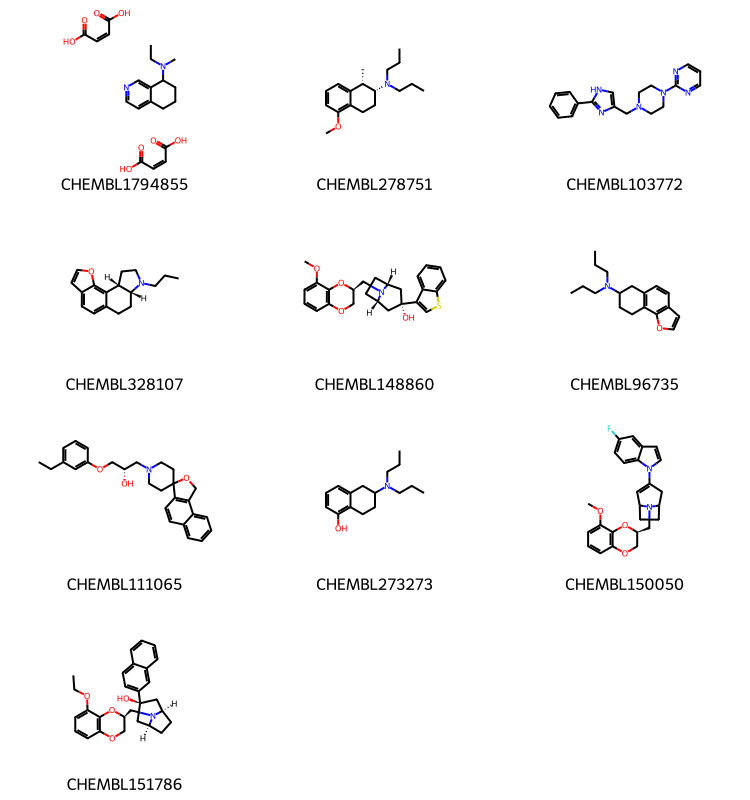

In [3]:
ms = [Chem.MolFromSmiles(smi) for smi in df.canonical_smiles]
Draw.MolsToGridImage(ms,legends=list(df.compound_chembl_id),molsPerRow=3,subImgSize=(250,200))

In [4]:
from rdkit import RDLogger
from rdkit.Chem import rdDistGeom
from rdkit.Chem import rdForceFieldHelpers
from rdkit.Chem.MolStandardize import rdMolStandardize

RDLogger.DisableLog('rdApp.info')
for i,m in enumerate(ms):
    ms[i] = Chem.AddHs(rdMolStandardize.ChargeParent(m))
RDLogger.EnableLog('rdApp.info')

params = rdDistGeom.ETKDGv3()
params.randomSeed = 0xf00d
params.numThreads=4
params.pruneRmsThresh = 0.5

for m in ms:
    rdDistGeom.EmbedMultipleConfs(m,5,params=params)
    rdForceFieldHelpers.MMFFOptimizeMoleculeConfs(m,numThreads=4)

Split the multi-conf molecules out into single conf molecules

In [5]:
ms_3d = []
for m in ms:
    for conf in m.GetConformers():
        nm = Chem.Mol(m)
        nm.RemoveAllConformers()
        nm.AddConformer(conf)
        ms_3d.append(nm)
len(ms_3d)

44

In [6]:
from rdkit.Chem import rdEHTTools
eht_results = []
for i,m in enumerate(ms_3d):
    ok,res = rdEHTTools.RunMol(m)
    if not ok:
        continue
    d = {'atomic_charges':list(res.GetAtomicCharges())}
    opm = res.GetReducedOverlapPopulationMatrix()
    bnds = []
    nats = m.GetNumAtoms()
    for bond in m.GetBonds():
        a1 = bond.GetBeginAtomIdx()
        a2 = bond.GetEndAtomIdx()
        if a1<a2:
            a1,a2 = a2,a1
            
        o = opm[(a1*(a1+1))//2 + a2]
        bnds.append(o)
    d['mulliken_overlap_pops'] = bnds
    eht_results.append(d)


!!! Warning !!! Distance between atoms 51 and 19 (0.966464 A) is suspicious.
!!! Warning !!! Distance between atoms 51 and 19 (0.973797 A) is suspicious.
!!! Warning !!! Distance between atoms 51 and 19 (0.973519 A) is suspicious.
!!! Warning !!! Distance between atoms 51 and 19 (0.977260 A) is suspicious.
!!! Warning !!! Distance between atoms 51 and 19 (0.973662 A) is suspicious.
!!! Warning !!! Distance between atoms 43 and 11 (0.972677 A) is suspicious.
!!! Warning !!! Distance between atoms 43 and 11 (0.976641 A) is suspicious.
!!! Warning !!! Distance between atoms 43 and 11 (0.972467 A) is suspicious.
!!! Warning !!! Distance between atoms 43 and 11 (0.972150 A) is suspicious.
!!! Warning !!! Distance between atoms 43 and 11 (0.971441 A) is suspicious.
!!! Warning !!! Distance between atoms 38 and 13 (0.968572 A) is suspicious.
!!! Warning !!! Distance between atoms 38 and 13 (0.970667 A) is suspicious.
!!! Warning !!! Distance between atoms 38 and 13 (0.969021 A) is suspicious.

In [7]:
len(ms_3d),len(eht_results)

(44, 44)

At this point we have a list of 3D molecules and a separate list of calculated values for each molecule.

This is the starting point for registration

In [8]:
import lwreg
from lwreg import standardization_lib
from lwreg import utils

config = lwreg.utils.defaultConfig()
# set the name of the database we'll work with:
config['dbname'] = 'lwreg_3dexperiments_demo.sqlt'
# By the time we load the conformers, the molecules will have already been standardized,
#  don't repeat it!
config['standardization'] = standardization_lib.NoStandardization()
config['registerConformers'] = True
lwreg.set_default_config(config)

Initialize the database. **Note** that this erases everything in the current database, so be very careful with this command!

In [9]:
lwreg.initdb()

This will destroy any existing information in the registration database.
  are you sure? [yes/no]: yes


True

Register all of our compounds at once:

In [11]:
# now bulk register. We want to also collect IDs of compounds which were already registered.
reg_ids = lwreg.bulk_register(mols=ms_3d,failOnDuplicate=False)
print(f'Registered {len(reg_ids)} unique conformers.')

Registered 44 unique conformers.


The returned values are (molregno,conf_id) pairs:

In [12]:
reg_ids[:10]

((1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (2, 10))

Get the registered mol blocks from lwreg. When `registerConformers` is enabled, as it is here, the registered structure is the first conformer registered for each molecule.

In [13]:
molregnos,conf_ids = zip(*reg_ids)
molregnos = set(molregnos)
molregnos

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

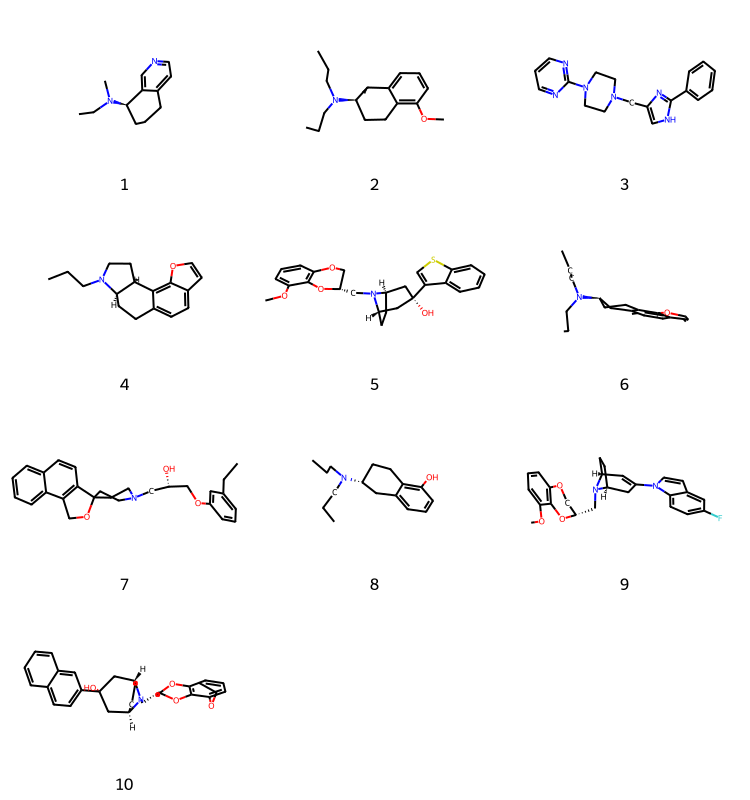

In [15]:
mol_data = lwreg.retrieve(ids=molregnos)
mids,new_mols = zip(*[(mid,Chem.MolFromMolBlock(d)) for mid,(d,_) in mol_data.items()])
Draw.MolsToGridImage(new_mols,legends=[str(x) for x in mids],molsPerRow=3,subImgSize=(250,200))

The 2D drawings of the 3D structures don't look so great...

# Set up database to hold experiments and results:

Initialize the experiment database:

In [18]:
config

{'dbname': 'lwreg_3dexperiments_demo.sqlt',
 'dbtype': 'sqlite3',
 'standardization': <lwreg.standardization_lib.NoStandardization at 0x7f90fa6a6800>,
 'removeHs': 1,
 'useTautomerHashv2': 0,
 'registerConformers': True,
 'numConformerDigits': 3,
 'hashConformer': 0,
 'lwregSchema': ''}

In [19]:
cn = utils.connect(config)
curs = cn.cursor()
# if I were working with postgresql, I'd put the experimental data in a separate
# schema. sqlite doesn't seem to support that
curs.execute('drop table if exists experiments_metadata')
curs.execute('create table experiments_metadata (expt_uid text primary key,metadata jsonb)')
curs.execute('drop table if exists experiments_data')
curs.execute('create table experiments_data (expt_uid text not null,conf_id int not null,data jsonb)')
cn.commit()

In [20]:
from datetime import datetime
def non_default_params_to_dict(obj,defaults):
    res = {}
    for k in dir(obj):
        if k.startswith('__'):
            continue
        v = getattr(obj,k)
        if callable(v):
            continue
        if v == getattr(defaults,k):
            continue
        else:
            res[k] = v
    return res


# Capture info about the conformer generation

Register the experiment

In [21]:
from datetime import datetime
dg_metadata = non_default_params_to_dict(params,rdDistGeom.ETKDGv3())

cg_expt_metadata = {
    'Experiment Type':'Conformer generation',
    'Method': 'ETKDGv3',
    'RDKit Version': rdkit.__version__,
    'Date': str(datetime.now()),
    'target_num_conformers':5,
    'note':'conformer generation then MMFF94 minimization'
}
cg_expt_metadata.update(dg_metadata)

In [22]:
import json
import uuid
cg_expt_uid = str(uuid.uuid4())
curs.execute('insert into experiments_metadata values (?,?)',(str(cg_expt_uid),json.dumps(cg_expt_metadata)))
cn.commit()

Store the association between the conformer ids and this experiment:

In [23]:
rows = [(cg_expt_uid,cid) for cid in conf_ids]
curs.executemany('insert into experiments_data values (?,?,null)',rows)
cn.commit()

# Experiment 2: storing the partial charges and overlap populations

We have the results of the individual QM runs stored in the `eht_results` dictionary. Create a new experiment in the database and then store all of those results.


In [24]:
qm_expt_metadata = {
    'Experiment Type':'QM Single Point',
    'Method': 'eHT',
    'RDKit Version': rdkit.__version__,
    'Date': str(datetime.now()),
    'note': 'property calculation with mulliken charges and reduced overlap populations'
}
import json
import uuid
qm_expt_uid = str(uuid.uuid4())
curs.execute('insert into experiments_metadata values (?,?)',(str(qm_expt_uid),json.dumps(qm_expt_metadata)))
cn.commit()

In [25]:
rows = [(qm_expt_uid,cid,json.dumps(qmd)) for cid,qmd in zip(conf_ids,eht_results)]
curs.executemany('insert into experiments_data values (?,?,?)',rows)
cn.commit()

# Work with the data

Look at Mulliken overlap population as a function of bond distance and bond type for the C-C bonds in our little data set.

This is easier when using postgreSQL, where we can work directly with the jsonb type.

There's probably a better way than this to do it in sqlite

In [26]:
# pull the experimental data + molblock for the conformer for the results 
# of the QM experiment
rows = %sql sqlite:///lwreg_3dexperiments_demo.sqlt \
    select experiments_data.conf_id,data,molblock from experiments_data \
    join conformers using (conf_id) \
    where expt_uid=:qm_expt_uid;
cc_mops = []
cc_dists = []
cc_bos = []
for cid,jsond,molb in rows:
    qmd = json.loads(jsond)
    mops = qmd['mulliken_overlap_pops']
    mol = Chem.MolFromMolBlock(molb,removeHs=False)
    assert mol is not None
    conf = mol.GetConformer()
    for idx,mop in enumerate(mops):
        bnd = mol.GetBondWithIdx(idx)
        if bnd.GetBeginAtom().GetAtomicNum()==6 and bnd.GetEndAtom().GetAtomicNum()==6:
            dist = (conf.GetAtomPosition(bnd.GetBeginAtomIdx())-conf.GetAtomPosition(bnd.GetEndAtomIdx())).Length()
            cc_mops.append(mop)
            cc_dists.append(dist)
            cc_bos.append(bnd.GetBondType())
    

Done.


In [27]:
from collections import defaultdict
cc_dists_1 = defaultdict(list)
cc_mops_1 = defaultdict(list)
for bo,d,mop in zip(cc_bos,cc_dists,cc_mops):
    cc_dists_1[bo].append(d)
    cc_mops_1[bo].append(mop)
        

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

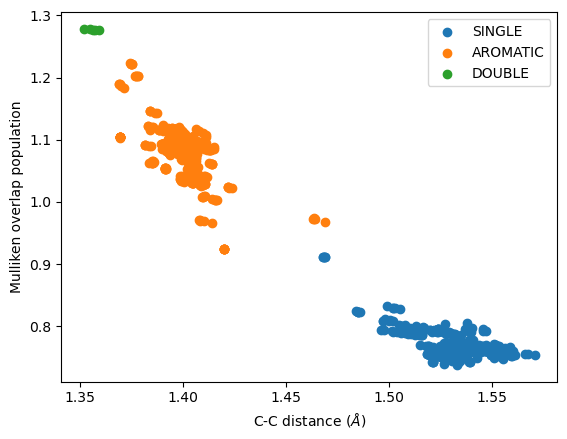

In [29]:
for k in cc_dists_1.keys():
    plt.scatter(cc_dists_1[k],cc_mops_1[k],label=str(k))
plt.legend()
plt.xlabel('C-C distance ($\AA$)')
plt.ylabel('Mulliken overlap population');